* En anteriores informes, hemos visto el bajo rendimiento que poseen los algoritmos de deep learning, lamentablemente probamos multiples configuraciones sobre los avances y diferentes implementaciones de canalizaciones sobre ellos, pero ninguno dio los resultados como yo esperaba, tener un modelo que supere el 99.99%.

A continuación mostraremos los resultados **SEMIFINALES** de los modelos seleccionados.


|N°|Algoritmo|Equilibrio de datos|Epocas|Train-Accuracy|Train-Recall|Validation-Accuracy|Validation-Recall|
|--|---------|----------|----------|--------------|------------|--------------|------------|
|1|Transfer-Learning sobre MobileNetV2|No balanceado|28|85.66%|83.22%|85.12%|85.52%|
|2|Transfer-Learning sobre MobileNetV2|Balanceado usando ponderacion de clases|21|83.13%|79.6%|82.64%|78.63%|
|3|ConvNet construida|Balanceado usando Ponderacion de clases|54|87%|86%|86%|85%|
|4|ConvNet construida|Balanceado usando Focal-Loss|48|89.0%|87.89%|87%|86%|
|5|Transfer-Learning sobre DenseNet169|Balanceado usando Focal-Loss|44|93%|93.39%|92.98%|92.38%|


* Si bien el modelo con **mayor puntaje posee 92%** de precision sobre datos de validacion, este no es suficiente, porque un margen de error del 8% puede costar millones de radiografias clasificadas incorrectamente.


### ALTERNATIVA:

* Una de las mejores alternativas que nos permitiran obtener mas puntaje es reduciendo el numero de clases haciendo uso de la seleccion de caracteristicas. De esta manera las clases **Lung Opacity** y **Pneumonia viral** quedaran bajo una categoria llamada **Enfermedades pulmonares** que no son COVID-19 ni mucho menos radiografias normales.

* Una observacion importante a realizar es que **NO SE DEBE RECURRIR A UNA CLASIFICACION BINARIA PARA ESTE TIPO DE CASOS**, asumir que daremos SI/NO ante una radiografia de COVID19 es inadecuada ya que es muy posible que una enfermedad pulmonar que posee los mismos rasgos respecto a su manifestacion en los pulmones que el COVID19 sea clasificada como tal, cuando en verdad no lo es. Debemos tener una clase intermedia entre **Normal** y **COVID19**. Y estas seran las **enfermedades pulmonares**.

#### PROCEDIMIENTO

* Recolectar los datos ubicados en las carpetas de dataset en train,val,split. y almacenarlos en DataFrames


In [1]:
import os 
import pandas as pd
path_train=r"..\Datasets\train"
path_val=r"..\Datasets\val"
path_test=r"..\Datasets\test"


def get_dataframe_folder(path="."):
    diccionario_frame={'ruta':[],'label':[]}
    for directorio in os.listdir(path):
        path_completo=os.path.join(path,directorio)
        for path_imagen in os.listdir(path_completo):
            diccionario_frame['ruta'].append(os.path.join(path_completo,path_imagen))
            diccionario_frame['label'].append(directorio)
    return pd.DataFrame(diccionario_frame)

In [32]:
frame_train=get_dataframe_folder(path_train)
frame_train.head()

,ruta,label
0,..\Datasets\train\COVID\COVID-1.png,COVID
1,..\Datasets\train\COVID\COVID-100.png,COVID
2,..\Datasets\train\COVID\COVID-1000.png,COVID
3,..\Datasets\train\COVID\COVID-1002.png,COVID
4,..\Datasets\train\COVID\COVID-1003.png,COVID


In [33]:
frame_val=get_dataframe_folder(path_val)
frame_val.head()

,ruta,label
0,..\Datasets\val\COVID\COVID-1009.png,COVID
1,..\Datasets\val\COVID\COVID-1010.png,COVID
2,..\Datasets\val\COVID\COVID-1020.png,COVID
3,..\Datasets\val\COVID\COVID-1022.png,COVID
4,..\Datasets\val\COVID\COVID-1024.png,COVID


In [3]:
frame_test=get_dataframe_folder(path_test)
frame_test.head()

,ruta,label
0,..\Datasets\test\COVID\COVID-10.png,COVID
1,..\Datasets\test\COVID\COVID-1001.png,COVID
2,..\Datasets\test\COVID\COVID-1008.png,COVID
3,..\Datasets\test\COVID\COVID-1012.png,COVID
4,..\Datasets\test\COVID\COVID-1015.png,COVID


* Nueva clasificacion de las clases **pneumonias** y **lung opacity**.

In [35]:
#para los datos de entrenamiento
frame_train['label'].replace({'Lung_Opacity':'Enfermedades Pulmonares No COVID19','Viral Pneumonia':'Enfermedades Pulmonares No COVID19'},inplace=True)
#para los datos de validacion
frame_val['label'].replace({'Lung_Opacity':'Enfermedades Pulmonares No COVID19','Viral Pneumonia':'Enfermedades Pulmonares No COVID19'},inplace=True)
#LOS DE DATOS DE TEST. TODAVIA NO SE TRANSFORMAN.

In [4]:
frame_test['label'].replace({'Lung_Opacity':'Enfermedades Pulmonares No COVID19','Viral Pneumonia':'Enfermedades Pulmonares No COVID19'},inplace=True)

In [5]:
#mover los archivos de pneumonia y lung opacity a sus respectivos destinos. Enfermedades pulmonares.
import shutil
def mover_enfermedades_pulmonares(dataframe,path):
    new_dir=os.path.join(path,'Enfermedades Pulmonares No COVID19')
    os.mkdir(new_dir)
    df_result=dataframe[dataframe.label=='Enfermedades Pulmonares No COVID19']['ruta']
    for ruta in df_result.tolist():
        print("Moviendo:",ruta," A ",new_dir)
        shutil.move(ruta,new_dir)

In [ ]:
mover_enfermedades_pulmonares(frame_train,path_train) #el movimiento de los datos de entrenamiento se ejecuta correctamente

In [ ]:
mover_enfermedades_pulmonares(frame_val,path_val) #el movimiento de los datos de validacion se ejecuta correctamente

In [ ]:
mover_enfermedades_pulmonares(frame_test,path_test)  #el movimiento de los datos de validacion se ejecuta correctamente

* Ahora que las clases se han fusionado, nos iremos a la fase de modelado para ingresar estos datos en la arquitectura del ultimo modelo con mas puntaje y asi poder disminuir el error de prediccion en los datos.

**Nuevos resultados**:


|N°|Algoritmo (3class)|Equilibrio de datos|Epocas|Train-Accuracy|Train-Recall|Validation-Accuracy|Validation-Recall|
|--|---------|----------|----------|--------------|------------|--------------|------------|
|1.B|Transfer-Learning sobre DenseNet169|Balanceo con Focal Loss|28|92%|91%|92%|91%|

### ALTERNATIVA 2: Equalizacion del SET de datos.

* Como los resultados no fueron por mucho los esperados, ahora realizamos una equalizacion de imagenes. Esto podria aumentar la calidad de las imagenes como esta:

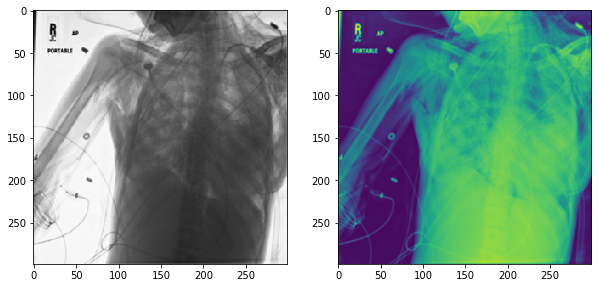

In [32]:
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
image_test=r"..\Datasets\train\Enfermedades Pulmonares No COVID19\Lung_Opacity-2173.png"
im=Image.open(image_test)
def compare_images(im1):
    fig,(ax1,ax2)=plt.subplots(1,2)
    fig.set_size_inches(10,10)
    ax1.imshow(im1,cmap="binary",interpolation="nearest")
    ax2.imshow(im1,cmap="viridis")
    plt.show()
compare_images(im)

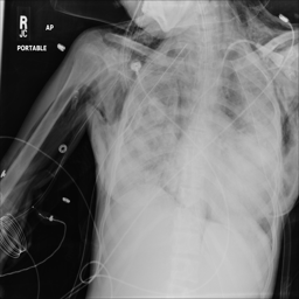

In [33]:
display(im)

In [34]:
import numpy as np

np.array(im)

array([[171, 190, 189, ...,  37,  35,  29],
       [196, 219, 216, ...,  40,  36,  31],
       [201, 223, 220, ...,  37,  35,  32],
       ...,
       [ 29,  26,  20, ...,  14,  15,  14],
       [ 19,  21,  20, ...,  12,  13,  12],
       [ 10,  13,  13, ...,  10,  11,  10]], dtype=uint8)

* A esta

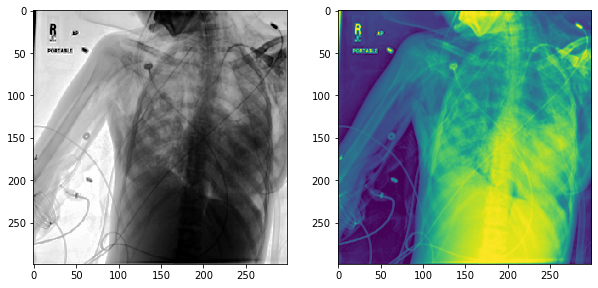

In [35]:
im_eq=ImageOps.equalize(im,mask=None)
compare_images(im_eq)

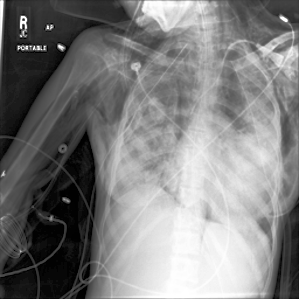

In [36]:
display(im_eq)

In [37]:
np.array(im_eq)

array([[183, 228, 226, ...,  63,  62,  56],
       [240, 255, 255, ...,  65,  62,  58],
       [250, 255, 255, ...,  63,  62,  59],
       ...,
       [ 56,  53,  46, ...,  36,  38,  36],
       [ 44,  47,  46, ...,  27,  32,  27],
       [ 20,  32,  32, ...,  20,  24,  20]], dtype=uint8)

### EQUALIZACION DE IMAGENES

* Reemplazamos cada imagen con su respectiva forma ecualizada.

In [50]:
import os

path_train=r"..\Datasets\train"
path_val=r"..\Datasets\val"
path_test=r"..\Datasets\test"
#funcion que acepta la raiz prin
def equalize(path):
    im=Image.open(path)
    im=ImageOps.equalize(im,mask=None)
    im.save(path)
    print(path,"EQUALIZADA")
    
def dir_equalization(root_path):
    for (root,directories,file_path) in os.walk(root_path):
        for directory in directories:
            dir_path=os.path.join(root,directory)
            for img_path in os.scandir(dir_path):
                equalize(img_path.path)


In [ ]:
dir_equalization(path_train) #La ecualizacion de las imagenes de entrenamiento se ejecuta correctamente

In [ ]:
dir_equalization(path_val) #La ecualizacion de las imagenes de validacion se ejecuta correctamente

In [ ]:
dir_equalization(path_test) #La ecualizacion de las imagenes de test se ejecuta correctamente

* Ahora las imagenes de entrenamiento, validacion y test estan ecualizadas. Y listas para el nuevo entrenamiento de datos.